<h1 id="tocheading">Zhou Shen's popularity overseas (Twitter & YouTube data)</h1>


## 1. Introduction
Zhou Shen, one of the top Chinese vocal singers, has come into the public view with his eye-catching performances in Singer 2020 and has become the hottest and the most sought-after singer in various shows in 2020. As an indicator of popularity in China, his followers on Weibo increased steadily from  2.42M to 5.84M throughout 2020, and notably, the figure increased by 178k in one day after his show of Da La Beng Ba (达拉崩吧）in Singer 2020 according to the data gathered by _@我就开个号追人_(Weibo) and _@与深同行呀_(Weibo). As one of the most viral shows in 2020, Da La Beng Ba not only has around 18.2M views on Bilibili but also above 11M views on YouTube (based on the data on 9th Jan 2020). Additionally, 17 videos of Zhou Shen's performances in Our Song (Season 1) have exceeded 1M views on YouTube on 11th Oct 2020 according to the data gathered by _@周深国际站_ (Weibo).

### Objective 
The purpose of this report is to analyze Zhou Shen's popularity overseas based on Twitter discussion volume and YouTube video statistics so as to have a brief overview of the international prospects of Zhou's career.
1. Analyzing the trend of the discussion volume and forecasting the future trend with time series analysis.
2. Analyzing the main languages used in tweets, the main contributors, and the hashtags used
3. Word cloud and sentiment analysis of tweets in English
4. Horizontal (with in the same variety show) and Vertical (with other Zhou's shows) comparison and visulization of YouTube data.

<img src="ZhouShen.jpg" alt="Drawing" style="width: 750px;"/>


##  2. Data Description 
The YouTube data is scrapped with YouTube API with the googleapiclient package from the playlists created by SMG Shanghai TV Official Channel, Pikachu (皮卡丘), and Zhou Shen Fan Club due to technical constraints. As a result, only the statistics of videos in these playlists are taken into consideration for the following analysis, even though it is common that there are several videos of the same performance uploaded. For Example, People In Love (天下有情人) uploaded by SMG Shanghai TV Official Channel has 4.75M views while the other video of the same show uploaded by SMG Music Channel has 5.02M views (data up to 9th Jan 2021). In this case, only one of them is taken into consideration for analysis for the sake of fairness for other singers in the same variety shows.

The tweets from Zhou Shen's debut (25th July 2020) to the end of 2020 were scrapped with the package Twint. The keywords used are ZhouShen and 周深 (Zhou Shen's name in Chinese) and duplicates tweets are removed before saving the data to a CSV file. Admittedly, there may be cases when only Zhou's nicknames are used in the tweets, these posts are not considered in this report.

### 2.1 YouTube Statistics (YouTube API)


In [2]:
# import the package
from googleapiclient.discovery import build
import json
import re
import pandas as pd
import demoji
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
from collections import Counter
import random

# install plotly for interactive graph
import plotly.graph_objs as go 
import plotly.express as px 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode 

# twitter scrapping
import nest_asyncio
nest_asyncio.apply()
import twint

# for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import itertools

# for sentiment analysis
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from gensim import corpora, models

import random
from google_trans_new import google_translator  
import time
import subprocess

%matplotlib inline

In [28]:
with open("youtube_api.json", "r") as file:
    API = json.load(file)
    
youtube = build('youtube', 'v3', developerKey = API['API'])


In [29]:
def youtube_scrapper(keyword, number, filename, show = None):
    playlist1 = youtube.search().list(part = "snippet", type = "playlist", q = keyword).execute()
    
    playlistID1 = playlist1['items'][0]['id']['playlistId'] # get the playlist Id
    allsongs1 = []
    nextPage_token1 = None
    
    while 1:
        songs1 = youtube.playlistItems().list(part = "snippet", playlistId = playlistID1, maxResults = 50, pageToken = nextPage_token1).execute()
        allsongs1 += songs1['items']
        nextPage_token1 = songs1.get('nextPageToken')
    
        if nextPage_token1 is None:
            break
        

    video_ids1 = list(map(lambda x:x['snippet']['resourceId']['videoId'], allsongs1))

    stas1 = []
    for ids in video_ids1:
        res = (youtube).videos().list(part = "statistics", id = ids).execute()
        stas1 += res['items']
        
    # create empty list to store information
    title1 = []
    liked1 = []
    disliked1 = []
    views1 = []
    videoid1 = []
    comment1 = []



    for i in range(0, number):
        title1.append((allsongs1[i])['snippet']['title'])
        liked1.append(int((stas1[i])['statistics']['likeCount']))
        disliked1.append(int((stas1[i])['statistics']['dislikeCount']))
        views1.append(int((stas1[i])['statistics']['viewCount']))
        videoid1.append(allsongs1[i]['snippet']['resourceId']['videoId'])
        try:
            comment1.append(int(stas1[i]['statistics']['commentCount']))
        except KeyError:
            comment1.append(None)
    
    
    # extract name of the song within 《》 from the title
    title2 = []
    for ti in title1:
        ti = ti.partition("《")[2].partition("》")[0]
        title2.append(ti)
    
    data1 = {"title": title2, "videoID": videoid1, "liked": liked1, "disliked": disliked1, "views": views1, "comment": comment1}
    df1 = pd.DataFrame(data1)
    df1['show'] = show  # create a column to indicate the variety shows
    df1.to_csv(filename, encoding='utf-8-sig', index = False)
    

In [48]:
# statistics of ZhouShen's shows in Singer 2020
youtube_scrapper('【周深】《歌手-當打之年》 歌曲純享版', 12, 'Singer_zs.csv', 'Singer2020')

# statistics of ZhouShen's shows in Our Song
youtube_scrapper('【周深】《我們的歌》歌曲純享', 20, 'OurSong_zs.csv', 'Our Songs')

# statistics of all lives in Singer 2020
youtube_scrapper('歌手當打之年純享', 101, 'Singer.csv', 'Singer2020') 

# statistics of all lives in Our Song
youtube_scrapper('纯享集合《我们的歌》', 81, 'OurSong.csv', 'Our Songs')  

### 2.2 Twitter Data (with Twint)

In [12]:
# twint twitter data
#scrap the tweets Zhoushen
import nest_asyncio
nest_asyncio.apply()
import twint

dataframes = pd.DataFrame()
keyword = ["周深", "ZhouShen"]
config = twint.Config()

def twint_search(key):
    config.Hide_output = True
    config.Search = key #keyword searched 
    config.Since = "2014-07-25"
    config.Until = "2021-01-01"
    config.Count = True
    config.Pandas = True

    #running search
    twint.run.Search(config)

    df = twint.storage.panda.Tweets_df
    dataframes.append(df)
    return(df)

df_ch = twint_search(keyword[0])
df_en = twint_search(keyword[1])

df_ch1 = df_ch[['date', 'tweet', 'language', 'hashtags', 'username', 'nlikes', 'nreplies', 'nretweets']]
df_en1 = df_en[['date', 'tweet', 'language', 'hashtags','username', 'nlikes', 'nreplies', 'nretweets']]

df = pd.concat([df_ch1, df_en1], axis=0, join='outer')
df = df.reset_index(drop=True)

#remove duplicate tweets
df = df.drop_duplicates(subset=['tweet'])

# save the dataframe to csv 
df.to_csv('tweet.csv', encoding='utf-8-sig', index = False)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 17118 Tweets.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 11338 Tweets.


In [4]:
# import the dataset
twitter = pd.read_csv("tweet.csv") # twitter data scrapped with twint 0n 16th Dec

zs_singer = pd.read_csv("Singer_zs.csv") 
zs_oursong = pd.read_csv('OurSong_zs.csv')
singer = pd.read_csv("Singer.csv") # youtube data for Singer2020
oursongs = pd.read_csv("OurSong.csv") #youtube data for Our Songs

## 3. Analysis of Twitter data (Frequency)
### 3.1 Trend Analysis

In [5]:
# data cleaning for twitter 
# change the date to timestamp
twitter['date'] = twitter['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())


In [6]:
# sort the dataframe according to time, reset the index
twitter = twitter.sort_values(by=['date'])
twitter = twitter.reset_index(drop=True)
display(twitter.head())

date                                              tweet language  \
0  2014-07-25  我將一部影片加到了 @YouTube 播放清單  http://t.co/xDFuRuK79...       zh   
1  2014-07-25                    中国好声音周深  http://t.co/WGCF0b6e9p       zh   
2  2014-07-26                                               周深 👍       ja   
3  2014-07-26                                      周深 so geng !!       ja   
4  2014-07-26  周深惊艳女声献唱《欢颜》 那英杨坤惊呆:男的?!: 周深的一首《欢颜》引来无数赞叹   导师...       zh   

  hashtags         username  nlikes  nreplies  nretweets  
0       []           jjy728       0         0          0  
1       []  MoneyHomeOnline       0         0          0  
2       []   exolkmseok_yyt       0         0          0  
3       []          WowoYin       1         0          0  
4       []          sub_pig       0         0          0

In [7]:
# daily discussion
twi_volume = pd.DataFrame(twitter.groupby('date')['tweet'].count())


In [8]:
twi_volume['date'] = twi_volume.index
twi_volume['year'] = twi_volume['date'].map(lambda x: x.year)
twi_volume['month'] = [d.strftime('%b') for d in twi_volume['date']]

# significant dates 
sig_dates = [datetime.date(2014,7,25), datetime.date(2014,8,29), datetime.date(2018,11,25),
             datetime.date(2018,12,2), datetime.date(2019,10,27), datetime.date(2020,1,19),
             datetime.date(2020,2,7),  datetime.date(2020,3,27), datetime.date(2020,4,24),
             datetime.date(2020,5,5), datetime.date(2020,7,25), datetime.date(2020,9,29), 
             datetime.date(2020,10,1), datetime.date(2020,11,10),datetime.date(2020,12,11),
             datetime.date(2020,12,18), datetime.date(2020,12,20), datetime.date(2020,12,27),
             datetime.date(2020,12,31)]

scatter = twi_volume[twi_volume.index.isin(sig_dates)]

text = ["<br>The Voice of China </br> ZhouShen's debut performance </br>",
       "<br>The Voice of China </br> Lake Baikal（贝加尔湖畔) </br>",
       "<br>The Masked Singer (season 3)</br> Moscow Outskirt's Night(莫斯科郊外的晚上) </br>",
       "<br>The Masked Singer (season 3)</br> Sound of Snow Falling (雪落下的声音)</br>",
       "<br>Our Song (Episode 1)</br> Monsters </br>",
       "<br>Our Song (Episode 12)</br> ZhouShen and Hacken Lee won the championship</br>",
       "<br>Singer 2020 (Episode 1)</br> Big Fish (大鱼）</br>",
       "<br>Singer 2020 (Episode 8)</br> Da La Beng Ba (达拉崩吧）</br>",
       "<br>Singer 2020 (Episode 12)</br>",
       "<br>Youth Choice Nighe</br> Zoobi Doobi, 千千阙歌",
       "<br>6th Anniversary of Debut</br> TME online concert</br> Bilibili BML Unravel",
       "<br>ZhouShen's 28 birthday </br> Birthday live streaming</br>",
       "<br> China-Chic Music Festival<br>",
       "<br>Tmall Carnival Shopping Night </br> Gokuraku Jodo (极乐净土)</br>",
       "<br>12.12 Super Night </br> Da La Beng Ba (达拉崩吧) + (画绢) </br>",
       "<br>Who's the Murder VI concert</br> Horror Rhymes (恐怖童谣)</br>",
       "<br> Tencent Star Awards </br> Deserted City (荒城渡）+ Who Am I to You (我是你的谁）</br>",
       "<br>Our Song (II) Returning singer </br> Love Suddenly (突如其来的爱情)</br>",
       "<br>New Year's Eve </br> 4 New Year's Eve/Gala, 7lives </br>"]

hovertext = ['<b>' + str(day) + '</b>' + text[i] for i, day in enumerate(sig_dates)]

fig = px.line(twi_volume, x = twi_volume.index, y = 'tweet', 
              title='Number of tweets about Zhou Shen over time',
              color = 'year', hover_data = ['tweet'],
              labels = {'year':'Year', 'tweet': 'Tweet Count',
                                       'x':'Date'})

fig.add_trace(go.Scatter(
    x=scatter.index,
    y=scatter.tweet,
    mode='markers',
    name='markers',
    hovertext=hovertext,
    hoverinfo="text",
    marker=dict(
        color="blue",
        size = [10]*19
    ),
    showlegend=False
))

fig.update_layout(xaxis_title="Date", yaxis_title="Tweet Frequency",
                 xaxis_range=[datetime.date(2014,7,25), datetime.date(2020,12,31)],
                 xaxis_rangeslider_visible=True,
                 yaxis_range = [0, 260])
fig.show()

Apart from a few scenarios, the tweets about Zhou Shen have remained almost rare until the end of 2018 when he appeared in Super-Vocal and The Masked Singer (season 3). The number of tweets daily increased significantly since the end of 2019 when Our Songs and Singer 2020 broadcasted successively. 

Notably, there are 699 tweets on 20th Dec 2020, to make the overall trend more obvious, the range of the y-axis is set to range from 0 to 260. This report will mainly focus on the period of 2019-2020 to analyze ZhouShen's popularity overseas especially after two highly-rated music variety shows, i.e. Our Song and Singer 2020.

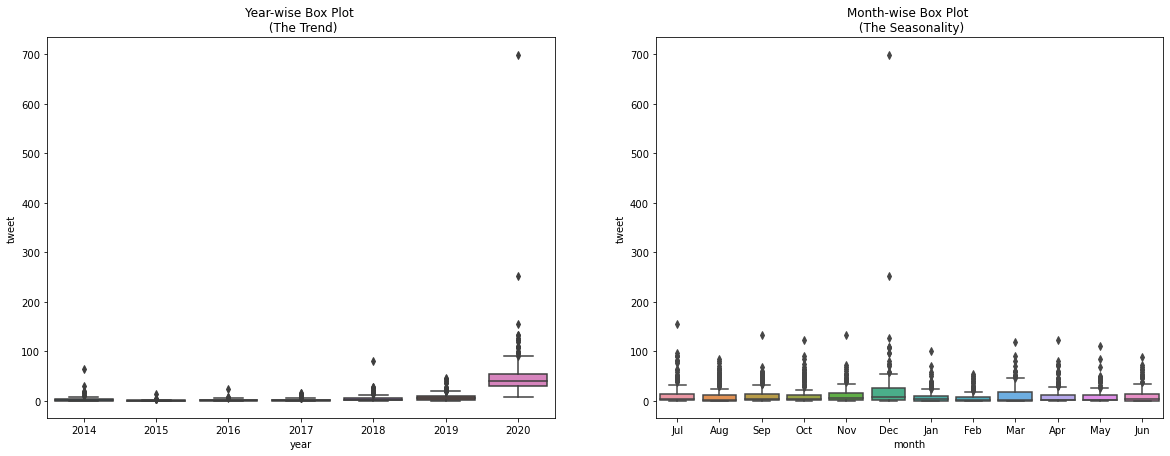

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))
sns.boxplot(x = 'year', y = 'tweet', data = twi_volume, ax = axes[0])
sns.boxplot(x= 'month', y = 'tweet', data = twi_volume, ax = axes[1])

axes[0].set_title('Year-wise Box Plot \n (The Trend)')
axes[1].set_title('Month-wise Box Plot \n (The Seasonality)')

plt.show()

In [11]:
fig = px.box(twi_volume[twi_volume['year']>= 2019], y = 'tweet', x = 'year', 
             points = 'all', title = 'Number of tweets about Zhou Shen everyday')
fig.update_layout(yaxis_range = [0, 260])
fig.show()

In 2020, the daily number of tweets usually falls within the range from 30 to 54, except when Zhou Shen had buzz performances such as 7 lives in 4 different New Year's Eve Galas and Tencent Star Awards. This can be also shown in the line graph above, where peak frequencies are marked with corresponding lives or performances on that day. On the other hand,  the majority of the figures in 2019 is around 10, which is much smaller than this year. There is an approximate exponential trend of tweets frequency, while the seasonality is not clear as it is unpredictable when Zhou would have exhilarating lives.

### 3.2 Time Series Analysis & Forecasting
Only the data after 1st July 2019 is considered for time series analysis, as these data are more relevant and can better represent Zhou Shen's recent years' popularity overseas.

In [12]:
# data preparation
twi_volume.index = pd.to_datetime(twi_volume.index)
twi_volume = twi_volume.resample('D').sum()

### 3.2.1 Decomposition of the Data and Stationarity Testing

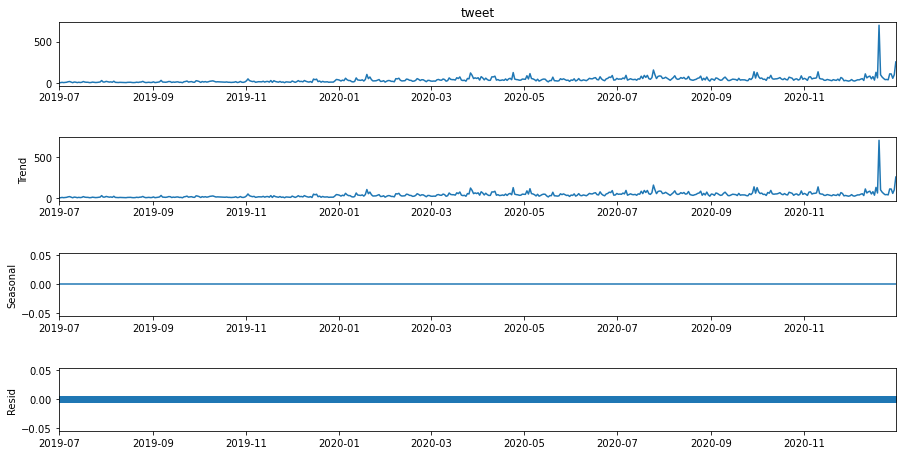

In [13]:
# decompose the data
y = twi_volume['tweet']
y = y['2019-07-01':]
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', period = 1)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(y)

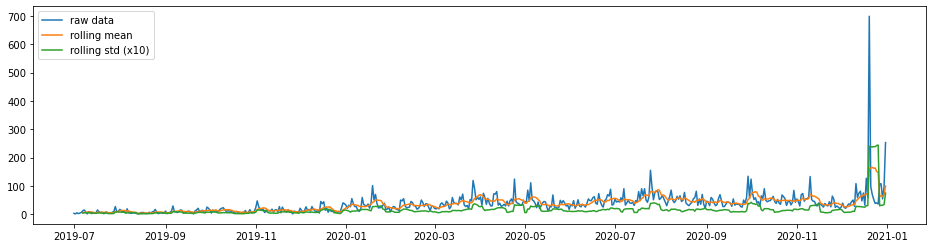

In [11]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [12]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.105
P-value = 0.243
Critical values :
	1%: -3.4425405682241816 - The data is not stationary with 99% confidence
	5%: -2.8669171671779816 - The data is not stationary with 95% confidence
	10%: -2.5696338432333636 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -11.916
P-value = 0.000
Critical values :
	1%: -3.442563336759378 - The data is  stationary with 99% confidence
	5%: -2.866927190004947 - The data is  stationary with 95% confidence
	10%: -2.5696391843672695 - The data is  stationary with 90% confidence


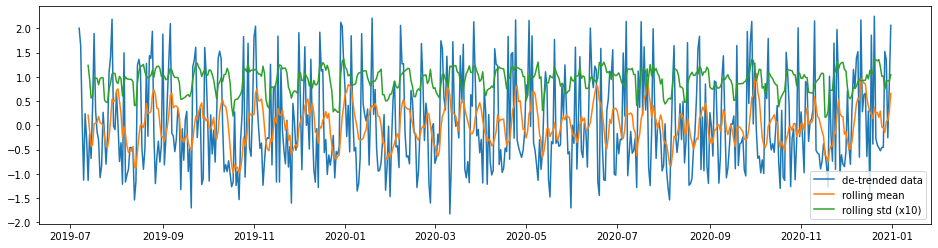

In [13]:
# detrending
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

There is an obvious trend in the raw data, so this time series of daily tweet amount is not stationary according to the Augmented Dickey-Fuller Test as its mean and variance vary with time, as shown in the line graph above. The data need to be stationarized by getting rid of the trend to make further analysis and forecasting. After detrending the data, it became stationary with a little fluctuation in mean and variance.

### 3.2.2 Time Series Model Fitting
The data is split into training and testing datasets for cross-validation. The MSE, calculated by $MSE = 1/_n \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$, is used as the loss function for model selection. The time series model with the lowest MSE is selected for further forecasting.


In [14]:
# split the data into training and testing dataset 
y_train = y[:'2020-11-01'] #training dataset
y_test = y['2020-11-02':] #testing dataset

predict_date = len(y_test)

### A. ARIMA Model
Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. There are three parameters (p,d,q) to be determined by grid search using AIC measures to achieve the best performances. The AIC measures how well a model fits the data while taking into account the complexity of the model. The ARIMA model with the lowest AIC value is selected. The range of grid search is from 0 to 7, as most variety shows are weekly broadcasted.

In [95]:
# find the best tuning parameters (with the lowest AIC)
def arima_grid_search(y):
    p = d = q = range(0,7)
    pdq = list(itertools.product(p,d,q))
    
    mini = float('+inf')
    
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            
            if results.aic < mini:
                mini = results.aic
                param_min = param
                # print(param_min, mini)
                
        except:
            continue
            
    print(param_min, mini)
    
arima_grid_search(y)

C:\Users\Chenx\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\Chenx\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 1, 6) 5350.4571650693215


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4071      0.254     -5.533      0.000      -1.906      -0.909
ar.L2         -1.4343      0.148     -9.687      0.000      -1.724      -1.144
ar.L3         -0.9006      0.240     -3.753      0.000      -1.371      -0.430
ma.L1          0.5741      0.257      2.237      0.025       0.071       1.077
ma.L2          0.3094      0.086      3.617      0.000       0.142       0.477
ma.L3         -0.3699      0.127     -2.910      0.004      -0.619      -0.121
ma.L4         -0.8531      0.241     -3.539      0.000      -1.326      -0.381
ma.L5         -0.1169      0.053     -2.210      0.027      -0.221      -0.013
ma.L6         -0.2039      0.042     -4.872      0.000      -0.286      -0.122
sigma2      1102.2530     18.028     61.141      0.000    1066.919    1137.587


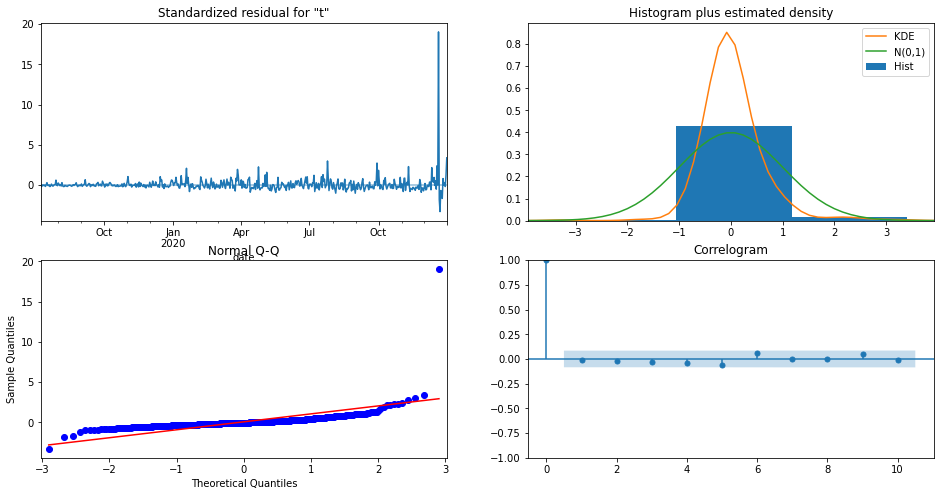

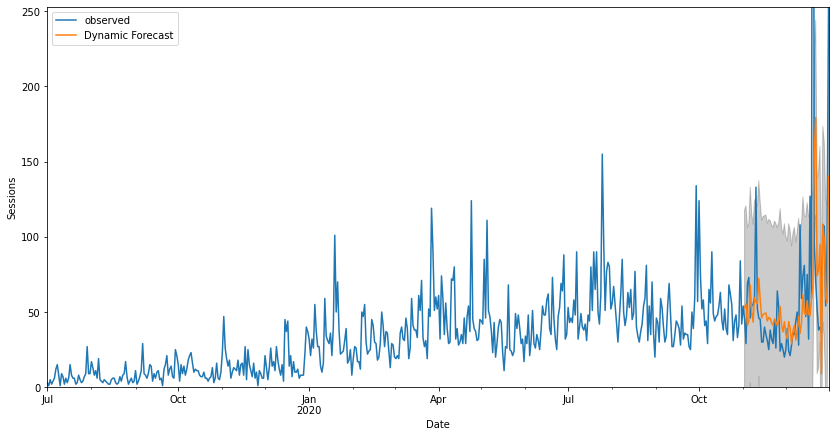

The MSE of ARIMA(3,1,6) is:  7745.667156497732


In [15]:
# fit ARIMA (3,1,6) model
model = sm.tsa.statespace.SARIMAX(y, order = (3,1,6), enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2020-11-02'), dynamic=False, full_results=True)
pred_ci = pred.conf_int()
y_forecasted_dynamic = pred.predicted_mean
mse = ((y_forecasted_dynamic - y_test) ** 2).mean()


ax = y.plot(label='observed')
ax.set_ylim(0, 253)
y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sessions')

plt.legend()
plt.show()

print('The MSE of ARIMA(3,1,6) is: ', mse)



The ARIMA(3,1,6) captures the general trend of data with the MSE equal to 7745.67. Also, the residuals of this model are independent and normally distributed according to the QQ-plot and Correlogram respectively. However, when it comes to the bursting time of tweets, the ARIMA model tends to underestimate the number of tweets, and the number of tweets even occasionally falls beyond the 95% confidence interval.

### B. Holt’s Linear Trend Method


The MSE of Holt's Linear Trend Method is 7814.666440268097


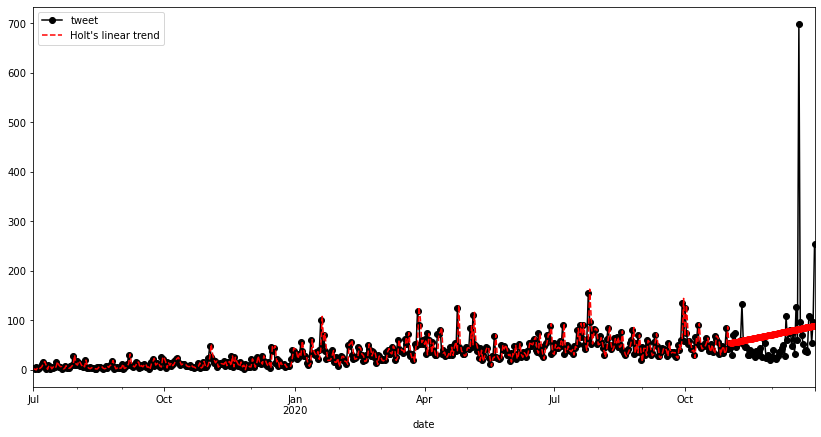

In [15]:
from statsmodels.tsa.api import Holt

y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
fit1 = Holt(y_train).fit(0.9, 0.2, optimized=False) #parameters selected by trials and errors that gives the lowest MSE
fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
mse1 = ((fcast1 - y_test) ** 2).mean()

print("The MSE of Holt's Linear Trend Method is", mse1)

fit1.fittedvalues.plot(style='--', color='red')
fcast1.plot(color='red', marker="o", legend=True)

plt.show()

The Holt method calculates the forecasting data using a weighted average with a trend. The level smoothing parameter $\alpha$ and the trend smoothing parameter $\beta$ are selected by trials and errors to get the smallest MSE (7814.67). As shown in the visualization for the Holt method above, it captures the general upward trend without considering the fluctuation, which is unlikely to take place in real life.

As a result, ARIMA(3,1,6) model is selected for forecasting because of smaller MSE.

|Method|ARIMA|Holt’s Method|
|------|-----|-------------|
|MSE|7745.67|7814.67|





### 3.2.3 Forecasting ARIMA(3,1,6)

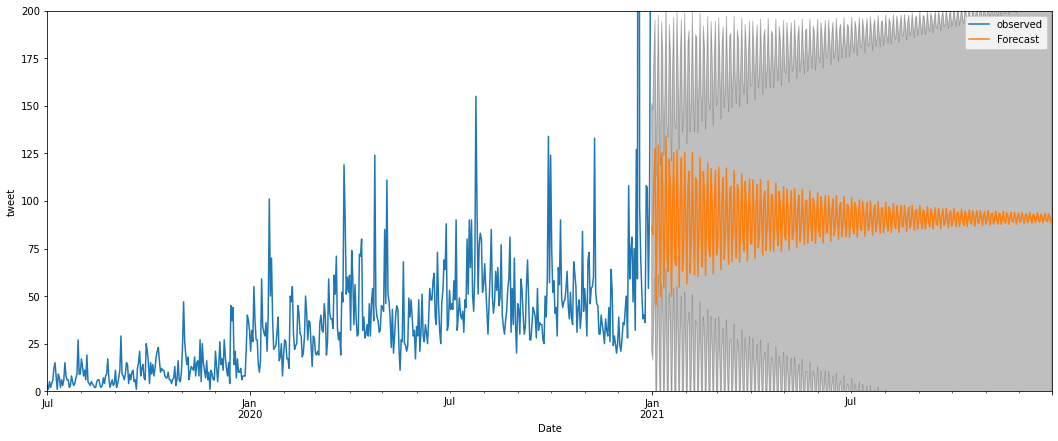

In [16]:
pred_uc = results.get_forecast(steps=365)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(18, 7))
ax.set_ylim(0, 200)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

In [17]:
# print(pred_uc.predicted_mean.describe())
# visualize the prediction,and data in 2020
fig = go.Figure()

fig.add_trace(go.Box(y = twi_volume[twi_volume['year'] == 2020]['tweet'], name= "Observed data (2020)"))
fig.add_trace(go.Box(y = pred_uc.predicted_mean, name = 'Predicted data (2021)'))
fig.update_layout(title_text="Number of tweets about Zhou Shen", yaxis_range = [0, 260])
fig.show()

Due to the mean-reverting property of the ARIMA (3,1,6) model as well as the underestimation of peaks, the forecasting with this model can only be used to get an overall picture of Zhou Shen's popularity overseas next year. Discussion about Zhou Shen is predicted to grow significantly with the interquartile range from 85 to 96 in 2021. Even though there is no comparison with other Chinese celebrities in sections 3.1 and 3.2, we can still conclude from the analysis above that Zhou Shen's future is promising not only in China but also overseas.

### 3.3 Analysis of Language Component

In [18]:
twi_lan = twitter.groupby('language')['tweet'].count()
twi_lan = pd.DataFrame(twi_lan.reset_index())

twi_lan.loc[twi_lan['tweet'] < 100, 'language'] = 'Other languages' # Represent only large countries


main_lan = list(twi_lan[twi_lan['tweet'] > 100]['language']) # define the main language, and convert the rest to other
main_lan.remove('und')

# change the notation of language
langauge_dic = {'en': 'English', 'in': 'Indonesian', 'ja': 'Japanese', 'th': 'Thai', 'tl': 'Filipino', 'zh': 'Chinese',
               'ko': 'Korean', 'vi': 'Vietnamese', 'pt': 'Portuguese', 'es': 'Spanish', 'cs':'Czech'}
for key, value in langauge_dic.items():
    twi_lan.loc[twi_lan[twi_lan['language'] == key].index, 'language'] = value
    
fig = px.pie(twi_lan, values='tweet', names='language', title='Language distribution', color_discrete_sequence= px.colors.sequential.PuBu_r)
fig.show()

Surprisingly, there are 30.6% of tweets about Zhou Shen are in Japanese which can probably indicate his popularity in Japan. This can be partially explained by his several brilliant lives in Japanese such as Gokuraku Jodo and Unravel，his Chinese covers of famous Japanese animation ost, and his strong ACG attributes. Also, there are a significant amount of tweets in Korean, Indonesian, Thai, etc. in addition to Chinese and English.

In [19]:
# changes of language contribution over years
twitter1 = twitter.copy() # make a copy of twitter datafram
twitter1.loc[twitter1[~twitter1['language'].isin(main_lan)].index, 'language'] = 'Other'

twitter1['year'] = twitter1['date'].map(lambda x: x.year) # add a column of year 
twi_year = twitter1.groupby(by=['year', 'language'])['tweet'].count()
twi_year = twi_year.reset_index()

# change the notation of language
for key, value in langauge_dic.items():
    twi_year.loc[twi_year[twi_year['language'] == key].index, 'language'] = value

fig = px.bar(twi_year, x='year', y = 'tweet', color = "language", title = "Language distribution over time",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

The yearly amount of tweets about Zhou Shen increased exponentially. Among these discussions, Japanese, English, and Korean speakers took more and more significant parts over time. Also, the language portfolios are becoming more and more diversified in recent years compared with previous years.

### 3.4 Analysis of Main Contributors

In [20]:
# main contributor analysis
contri_time = pd.DataFrame(twitter.groupby(['date', 'username'])['tweet'].count().reset_index())
contri = pd.DataFrame(twitter.groupby(['username'])['tweet'].count().reset_index())
contri = contri.sort_values(by=['tweet'], ascending = False, ignore_index = True) #sort the contri df by number of tweets

contri['tweet'].describe()



count    6933.000000
mean        3.413385
std        21.150074
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       909.000000
Name: tweet, dtype: float64

In [21]:
contri.loc[contri['tweet'] <= 100, 'username'] = 'other'

px.pie(contri, values = 'tweet', names = 'username', color_discrete_sequence= px.colors.sequential.PuBu_r,title = 'Contribution by users')

In [22]:
main_contri = list(contri.loc[0:10, 'username'])
fig = px.line(contri_time[contri_time['username'].isin(main_contri)], x = 'date', y = 'tweet', color = 'username')

fig.update_layout(xaxis_title="Date", yaxis_title="Tweet Frequency",
                 xaxis_range=[datetime.date(2018,9,1), datetime.date(2020,12,16)],
                 xaxis_rangeslider_visible=True,
                 title = 'Daily tweets by Main Contributors')

fig.show()

Among all tweets about Zhou Shen scrapped, about 71.5% of them were posted by users who posted less than 100 tweets about Zhou in total. They can be probably viewed as "passersby" who happened to watch Zhou's shows and posted their opinions instead of his fans. The interquartile range for numbers of tweets by usernames is from 1 to 2, which proved the fact that the majority of tweets were posted by "passersby". As a result, these tweets can be used for analyzing general opinions about Zhou Shen overseas.

6 of the top 10 active accounts including a fan club (charliepop929), that tweet frequently about Zhou Shen, started to post actively about Zhou Shen in 2020. This aligns with the progress of Singer 2020 as well as his clout in terms of lives after Singer 2020. The other three active accounts including the major fan club (ZHOUSHEN_INTL) started posting about Zhou much earlier than 2020. For example, ZHOUSHEN_INTL started working in March 2019.

### 3.5 Hashtags Frequency

In [23]:
hashtag = list(twitter['hashtags'])
hashtag = ['No Hashtags' if hasht == '[]' else hasht for hasht in hashtag] # replace [] with No Hashtags

tags = []
for hast in hashtag:
    if hast == 'No Hashtags':
        tags.append(hast)
    else:
        split_list = hast.split(",") #split string into a list
        for sl in split_list:
            tags.append(re.sub(r'[^\w\s]','',sl).strip()) #r remove punctuation
            
hashtags = pd.DataFrame.from_dict(Counter(tags), orient='index').reset_index() # count the frequency and convert it to df
hashtags.columns = ['tag', 'freq'] #rename the column
hashtags = hashtags.sort_values(by = ['freq'], ascending = False, ignore_index = True) # sort the hashtags by freq
# hashtags.head(20)

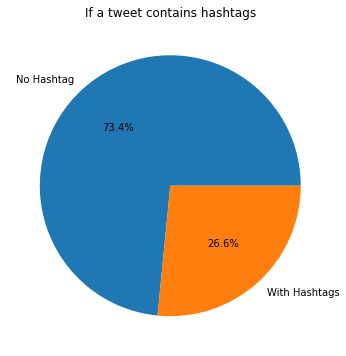

In [24]:
twitter['tag'] = 'Yes'
twitter.loc[twitter[twitter['hashtags'] == '[]'].index, 'tag'] = 'No'

fig1, ax1 = plt.subplots(figsize = (6,6))
ax1.pie(twitter.groupby(by = ['tag'])['tweet'].count(), 
        labels = ['No Hashtag', 'With Hashtags'], 
        autopct='%1.1f%%')
ax1.set_title('If a tweet contains hashtags')
plt.show()

In [25]:
fig = px.bar(hashtags.loc[1:16, :], x = 'tag', y ='freq', title = 'Frequency of Hashtags used')
fig.show()

Among all the tweets scrapped, only 26.6% of them involve one or more hashtags. For tweets with hashtags, the most frequently used tags are Zhou Shen's name in different languages, his English Charlie as well as his username in Weibo, i.e. 卡布 or 卡布叻. Also, the variety shows that Zhou appeared, such as Singer 2020, Go Newbies (新手驾到), and Youth Periplous 2 (青春环游记2), are used as hashtags as well. Additionally, the hashtag of Zhou Shen's Studio, founded in July 2020, was usually mentioned. 

### 3.6 Sentiment Analysis

In [26]:
# only English tweets are used for sentiment analysis
senti_twi = twitter[twitter['language'] == 'en'].copy()
senti_twi['year'] = senti_twi['date'].map(lambda x: x.year)

In [27]:
# download the latest emojis
demoji.download_codes()

... OK (Got response in 0.49 seconds)
Writing emoji data to C:\Users\Chenx\.demoji\codes.json ...
... OK


In [28]:
# remove emojis in tweets
senti_twi['tweet'] = senti_twi['tweet'].apply(lambda x: demoji.replace(x, ""))

In [29]:
# remove url, mentions, hashtags
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) 
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text)


In [30]:
senti_twi['cleaned_tweets']=senti_twi['tweet'].apply(lambda x: process_text(x))
senti_twi['tweet']=senti_twi['tweet'].apply(lambda x: remove_content(x))

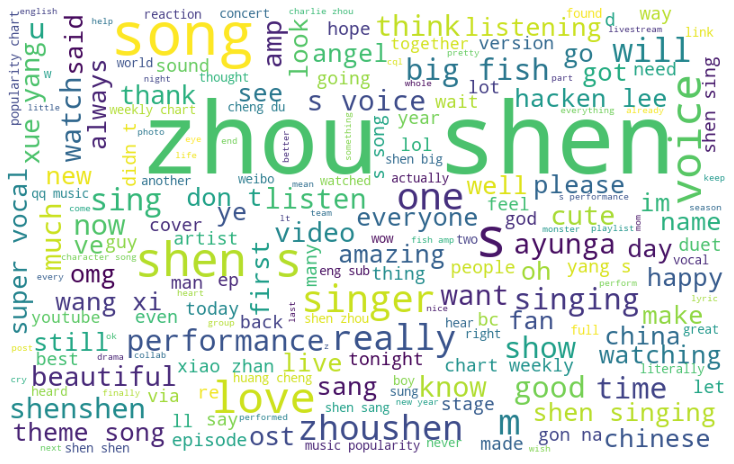

In [31]:
# word cloud
temp=' '.join(senti_twi['cleaned_tweets'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(temp)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

In [32]:
# sentiment & subjectivity
senti_twi['sentiment']=senti_twi['tweet'].apply(lambda x:TextBlob(x).sentiment[0])
senti_twi['subject']=senti_twi['tweet'].apply(lambda x: TextBlob(x).sentiment[1])
senti_twi['polarity']=senti_twi['sentiment'].apply(lambda x: 'pos' if x>=0 else 'neg')

In [33]:
fig=px.histogram(senti_twi, x='polarity', color='polarity', title = 'Sentiment Towards Zhou Shen')
fig.show()

In [34]:
fig = px.histogram(senti_twi, x = 'year', color = 'polarity', title = 'Sentiment over years')
fig.show()

Only English tweets are used for sentiment analysis due to technical and time constraints. Among all tweets scrapped, 27% of them are in English and the trend of discussion volume in English resembles that of overall data. So tweets in English can generally the overall sentiment towards Zhou Shen.

Among these 6k tweets, the most frequently mentioned words about Zhou Shen are his songs, such as Big Fish and Deserted City that is the character theme song of Xue Yang, and his singing. This is the same as what Zhou Shen expected, using his songs and performances to speak for himself. Several other words often appeared in tweets about Zhou such as voice, beautiful, amazing, and some singers that cooperated with him before. Besides, about 90% of the tweets in English have a positive view of Zhou Shen, and most of the negative tweets were posted this year.

## 4. Analysis of YouTube Data

In [35]:
ytb_statistics = pd.concat([zs_singer, zs_oursong], axis=0, join='outer') #join ZhouShen's lives together
display(ytb_statistics.head())

title      videoID   liked  disliked     views  comment        show
0     歌手·当打之年  dlBIJW2f8J4    5309       154    498748      716  Singer2020
1  不会拜拜的Disco  O_PDxfRVSys     388       184     43088      352  Singer2020
2    自己按门铃自己听  Ao1g_8vaNbc   16262       203   1488702     2248  Singer2020
3          相思  LjyzE8alASI    9525       168   1227969      522  Singer2020
4        达拉崩吧  XHedu3KcPP0  127076      3397  10932732    11090  Singer2020

In [36]:
# data cleaning for YouTube Data
performance = list(ytb_statistics['title']) # performance by ZhouShen

# create a column to indicate if a live is performed by ZhouShen 
singer['singer'] = 'Other'
singer.loc[singer[singer['title'].isin(performance)].index, 'singer'] = 'ZhouShen'

oursongs['singer'] = 'Other'
oursongs.loc[oursongs[oursongs['title'].isin(performance)].index, 'singer'] = 'ZhouShen'

# sort the singer data according to views
singer = singer.sort_values(by=['views'], ascending = False, ignore_index = True)

# change the title of the video with videoID 4fvUnPl5_BA
singer.loc[singer[singer['videoID'] == '4fvUnPl5_BA'].index, 'title'] = 'Manta'
# display(singer.head(20))

# sort the our songs data according to views
oursongs = oursongs.sort_values(by=['views'], ascending = False, ignore_index = True)
# display(oursongs.head(20))

In [37]:
colors1 = ['skyblue' if (singer =='ZhouShen') else 'lightgrey' for singer in singer.loc[0:20, ]['singer']]
colors2 = ['skyblue' if (singer =='ZhouShen') else 'lightgrey' for singer in oursongs.loc[0:20, ]['singer']]
# indicate ZhouShen's performances by blue

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles = ('Singer 2020', 'Our Song'),
                    shared_yaxes=True)

fig.add_trace(go.Bar(x = singer.loc[0:20,'title'], y = singer.loc[0:20, 'views'], marker_color = colors1), row = 1, col = 1)
fig.add_trace(go.Bar(x = oursongs.loc[0:20,'title'], y = oursongs.loc[0:20, 'views'], marker_color = colors2), row = 1, col = 2)

fig.update_layout(height = 600, width = 900, title_text = 'Views on YouTube (Singer 2020 & Our Song)', showlegend=False)
fig.update_xaxes(tickangle=45, tickfont=dict(size=10))

In [38]:
# visualization of ZhouShen's live only
# sum up the views, comments and etc. of duplicate rows
ytb_statistics = ytb_statistics.groupby(['title', 'show']).sum().reset_index()

fig = px.scatter(ytb_statistics, x = 'views', y = 'comment', size = 'liked', color = 'show', 
                 hover_name = 'title', title = "YouTube Statistics of Zhou Shen's performances", size_max=60)

fig.update_layout(xaxis_title="View", yaxis_title="Comment",
                 xaxis_rangeslider_visible=True)
fig.show()

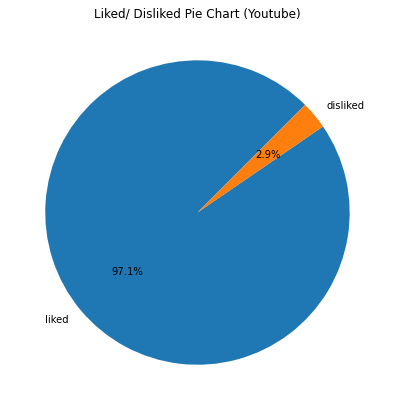

In [43]:
like = ytb_statistics.groupby(['show']).sum().reset_index()

plt.subplots(figsize = (7,7))
plt.pie([like['liked'].sum(), like['disliked'].sum()], labels = ['liked', 'disliked'], 
        startangle=45, autopct='%1.1f%%')
plt.title('Liked/ Disliked Pie Chart (Youtube)')

plt.show()

#### Analysis & Conclusion on YouTube Statistics ####
Da La Beng Ba (达拉崩吧) went viral on YouTube with the most comments（11k), likes(127k) and views (10.9M) among all shows in Singer 2020 just as its clout on Weibo, Bilibili, etc. in China. As one of Zhou Shen's representative songs, Big Fish (大鱼）is as popular overseas as in China among all of Zhou Shen's lives in these two music variety shows.

Also, among the top 20 viewed videos in both Singer 2020 and Our Song's official playlist, Zhou's performances， indicated by blue columns in the Views on YouTube bar chart，took about a quarter of each variety show, and the proportion is almost the highest among all singers in both variety shows. Besides, some of his videos, such as Big Fish (大鱼), Da La Beng Ba （达拉崩吧），Autumn Serenade (月半小夜曲）, and People In Love (天下有情人) , are in the lead in terms of views in both Singer 2020 and Our Song. Among all the feedbacks for Zhou Shen's performances in both variety shows shown by likes and dislikes on YouTube, 97% of them are positive, which can probably reflect overseas' sentiments towards him.

When it comes Zhou's own lives in these two variety shows, his performances in Our Song are overall more popular, in terms of views, comments, and likes, than those in Singer 2020 except Da La Beng Ba（达拉崩吧） and Big Fish (大鱼). Notably, Under Mount Fuji (爱情转移) sung by Zhou Shen and Hacken Lee in Our Song (season 2) as returning singers was released on 14th Dec this year, but there are already nearly 5k comments, which is the second-highest and indicates this song's potential trend in the future.

## 5. Conclusion
In conclusion, there is and will be a considerable upward trend in the number of tweets about Zhou Shen predicted by both time series models, and the language portfolios of his audience have become more and more diversified over years. Among all the tweets gathered, Asians took about 69%. However, we cannot conclude the level of his popularity internationally due to lack of horizontal comparisons with other singers, and the discussion volume could also be limited by the fact that Zhou Shen doesn't have a Twitter account and a significant proportion (approximately 7%~10%) of tweets were posted by fan clubs such as ZHOUSEHN INTL, Charliepop929, and other recently developed fan clubs.

There might be a way to go before Zhou Shen becomes an internationally well-known singer, but he took every step steadily with his full effort. This can be shown by the high quality of his shows indicated by around 90% positive feedback on Twitter and 97% on YouTube.

## 6. References
1. https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/
2. https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
3. https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
4. https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
5. https://towardsdatascience.com/analysis-on-tweets-using-python-and-twint-c7e6ebce8805
6. https://stackoverflow.com/questions/49497391/googletrans-api-error-expecting-value-line-1-column-1-char-0